In [3]:
# !pip install Sastrawi
# !pip install nlp-id
# !pip install emoji
# !pip install optuna
# !pip install gensim==4.3.2
# !pip install scikit-learn==1.2.2
# !pip install numpy==1.25.2

# Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
import spacy
import re
import json
import emoji
import optuna
import joblib
import json
import gensim

from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from spacy.lang.id.stop_words import STOP_WORDS
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from nlp_id.lemmatizer import Lemmatizer
from gensim.models import Word2Vec
from nlp_id.postag import PosTag
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 500)

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alfan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alfan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\alfan\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


# Load Tweet Dataset

## Set Parameters

In [5]:
path = os.getcwd()

resources_folder = 'resources'
resources_path = os.path.join(path, resources_folder)

dataset_folder = 'dataset'
dataset_path = os.path.join(path, dataset_folder)
dataset_name = 'tweet.csv'

model_folder = 'models'
model_path = os.path.join(path, model_folder)

# rf_model_sg_baseline = joblib.load(os.path.join(model_path, 'model_rf_sg_baseline.joblib'))
# rf_model_sg_tuned = joblib.load(os.path.join(model_path, 'model_rf_sg_tuned.joblib'))
# rf_model_cbow_baseline = joblib.load(os.path.join(model_path, 'model_rf_cbow_baseline.joblib'))
# rf_model_cbow_tuned = joblib.load(os.path.join(model_path, 'model_rf_cbow_tuned.joblib'))

word2vec_model_sg = os.path.join(model_path, 'word2vec_model_sg_min_8_window_6_no_sw.bin')
word2vec_model_cbow = os.path.join(model_path, 'word2vec_model_cbow_min_8_window_6_no_sw.bin')

## Load Dataset

In [6]:
df = pd.read_csv(os.path.join(dataset_path, dataset_name), encoding='utf-8')
df.head()

,Unnamed: 0,sentimen,tweet
0,0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini ðŸ‘‡ pasti hoax buatan penguas...
1,1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy? http://dlvr.it/R2pvZVÂ"
2,2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDe..."
3,3,positif,"Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliu..."
4,4,negatif,"Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ng..."


In [7]:
df.loc[0].values

array([0, 'negatif',
       'Kata @prabowo Indonesia tidak dihargai bangsa asing!   Berita ini ðŸ‘‡ pasti hoax buatan penguasa, ya kan @rockygerung?ðŸ˜œ https://twitter.com/mediaindonesia/status/1117575436337160192?s=21Â\xa0â€¦'],
      dtype=object)

In [241]:
df.drop('Unnamed: 0', axis=1, inplace=True) # drop column with 'Unnamed: 0' name

# Data Inspection

## Check Null Values

In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentimen  1815 non-null   object
 1   tweet     1815 non-null   object
dtypes: object(2)
memory usage: 28.5+ KB


In [243]:
df.isna().sum()/len(df) # check null values proportion

sentimen    0.0
tweet       0.0
dtype: float64

Dapat dilihat bahwa tidak terdapat null values di dataset yang kita gunakan. Artinya kita tidak perlu melakukan proses imputation.

## Check Label Proportion

In [244]:
df[['sentimen']].value_counts()

sentimen
positif     612
netral      607
negatif     596
dtype: int64

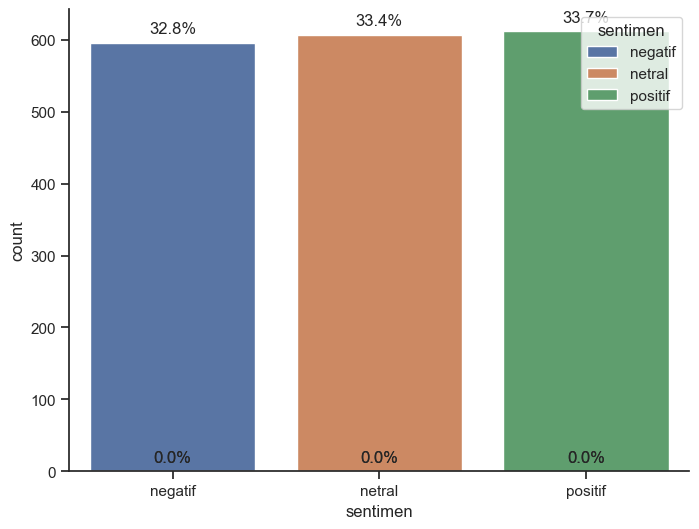

In [245]:
plt.figure(figsize=(8, 6), dpi=100)
ax = sns.countplot(data=df, x='sentimen', hue='sentimen', dodge=False)
total = float(len(df))  # total number of data points

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/total:.1%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

Label (sentimen) yang kita miliki cukup balance sehingga tidak perlu melakukan proses oversampling atau undersampling. Selain itu, kita dapat menggunakan metriks akurasi untuk mengukur performa model.

## Check Data Duplication

In [246]:
print('Number of rows before duplicates data dropped: ', len(df))
print('Number of rows after duplicates data dropped: ',len(df.drop_duplicates()))
print('Number of duplicated rows: ' , len(df) - len(df.drop_duplicates()))

Number of rows before duplicates data dropped:  1815
Number of rows after duplicates data dropped:  1815
Number of duplicated rows:  0


Tidak terdapat data yang duplicated dari dataset yang kita miliki.

# Text Preprocessing

In [247]:
with open(os.path.join(resources_folder,'slang_word_dictionary.json'), 'r') as json_file:
    slangword_dict = json.load(json_file)

In [248]:
with open(os.path.join(resources_folder,'emoji_dictionary.json'), 'r') as json_file:
    emoji_dict = json.load(json_file)

In [249]:
additional_stopwords = [
    'sih', 'nya', 'iya', 'pak', 'se', 'ya', 'ke', 'pa', 'om', 'hmmmmm', 'hmm', 'oh', 'eh', 'com'
]

excluded_stopwords = [
    'tidak', 'belum', 'bukan', 'tanpa', 'jarang', 'kurang', 'hampir tidak', 'tidak pernah',
    'belum pernah', 'tidak boleh', 'tidak bisa', 'tidak seharusnya', 'tidak mungkin',
    'tidak akan', 'tidak harus', 'tidak mengizinkan', 'tidak diizinkan', 'tidak diinginkan',
    'tidak disarankan', 'tidak disetujui', 'baik', 'bisa', 'mungkin', 'boleh', 'salah', 'semakin'
]

stop_words = set(stopwords.words('indonesian'))
stop_words_excluded = [value for value in stop_words if value not in excluded_stopwords] + additional_stopwords
stop_words_all = list(stop_words) + additional_stopwords

In [250]:
def random_tweet(before, after, low=0, high=10, length=len(df)):
      for i in np.random.randint(low, length, high):
        print("------------"*100)
        print(f'index {i}')
        print('before: ', before.loc[i])
        print('after: ', after.loc[i])

In [251]:
# Text processing function

def clean_tweet(text):
    cleaned_text = re.sub(r"#\w+", "", text)
    cleaned_text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', cleaned_text)  # Remove URLs starting with http/https
    cleaned_text = re.sub(r'www\.[^ ]+', '', cleaned_text)  # Remove www URLs
    cleaned_text = re.sub(r'pic\.twitter\.com/\S+', '', cleaned_text)  # Remove pic.twitter.com links
    cleaned_text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', cleaned_text)  # Remove emails
    cleaned_text = re.sub(r'<.*?>', '', cleaned_text) # Remove HTML
    cleaned_text = cleaned_text.replace('@', '')  # Remove @ in mentions

    return cleaned_text

def remove_emojis(text):
    emojis_to_remove = ["😂", "…", "👍", "😁", '😄','😆', '😊', '😭']
    for emoji in emojis_to_remove:
        text = text.replace(emoji, "")
    return text

def extract_emojis(text):
    emojis = [c for c in text if c in emoji.EMOJI_DATA]
    combined_emoji = ''.join(emojis)
    return combined_emoji

def process_punctuation(text):
    modified_text = re.sub(r'[-\']', '',text)
    return modified_text

def remove_punctuation(text):
    punctuation_pattern = r'[^\w\s]'
    cleaned_text = re.sub(punctuation_pattern, ' ', text)
    return cleaned_text

def remove_extra_spaces(text):
    extra_spaces_pattern = r"\s+"
    cleaned_text = re.sub(extra_spaces_pattern, " ", text)
    cleaned_text = cleaned_text.strip()
    return cleaned_text

def remove_special_characters(text):
    cleaned_text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)
    return cleaned_text

def lowercase(text):
    lowercase_text = text.lower()
    return lowercase_text

def process_slang(text, dictionary=slangword_dict):
    pattern_short_words = re.compile(r'\b(?:' + '|'.join(re.escape(word) for word in dictionary.keys()) + r')\b')
    output_text = pattern_short_words.sub(lambda x: dictionary[x.group()], text)
    return output_text

def remove_stopwords(text, stopwords=stop_words_excluded):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words_excluded]
    cleaned_text = ' '.join(filtered_tokens)
    return cleaned_text

def remove_specific_numbers(text):
    pattern = re.compile(r'\b(?!2\b|1\b|2019\b)\d+\b')
    result = re.sub(pattern, '', text)
    return result

# Text normalization function
lemmatizer = Lemmatizer()

def custom_lemmatization(text, exclude_words=[]):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) if word.lower() not in exclude_words else word for word in words]
    lemmatized_text = ' '.join(lemmatized_words)

    return lemmatized_text

def get_english_words(word_list):
    english_words = set(words.words())
    return [word for word in word_list if word.lower() in english_words]

# Word embedding
def mean_vector_df_val(model, train_sentences, val_sentences, test_sentences):
    # train
    vectorized_lists_train = []
    for word_list in train_sentences:
        vectorized_words_train = [model.wv[word] for word in word_list if word in model.wv]  # OOV handler (ignore)
        vectorized_lists_train.append(vectorized_words_train)

    mean_vector_train = []
    for matrix in vectorized_lists_train:
        transposed_matrix_train = list(map(list, zip(*matrix)))
        column_means_train = [sum(column) / len(column) for column in transposed_matrix_train]
        mean_vector_train.append(column_means_train)

    X_train_mean_vector = pd.DataFrame(np.array(mean_vector_train))

    # validation
    vectorized_lists_val = []
    for word_list in val_sentences:
        vectorized_words_val = [model.wv[word] for word in word_list if word in model.wv] #OOV handler (ignore)
        vectorized_lists_val.append(vectorized_words_val)

    mean_vector_val = []
    for matrix in vectorized_lists_val:
        transposed_matrix_val = list(map(list, zip(*matrix)))
        column_means_val = [sum(column) / len(column) for column in transposed_matrix_val]
        mean_vector_val.append(column_means_val)

    X_val_mean_vector = pd.DataFrame(np.array(mean_vector_val))

    # Test
    vectorized_lists_test = []
    for word_list in test_sentences:
        vectorized_words_test = [model.wv[word] for word in word_list if word in model.wv] #OOV handler (ignore)
        vectorized_lists_test.append(vectorized_words_test)

    mean_vector_test = []
    for matrix in vectorized_lists_test:
        transposed_matrix_test = list(map(list, zip(*matrix)))
        column_means_test = [sum(column) / len(column) for column in transposed_matrix_test]
        mean_vector_test.append(column_means_test)

    X_test_mean_vector = pd.DataFrame(np.array(mean_vector_test))

    return X_train_mean_vector, X_val_mean_vector, X_test_mean_vector

# Modelling
def evaluate_classification_model(y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred, model_name=''):
    train_accuracy = round(accuracy_score(y_train, y_train_pred), 2)
    val_accuracy = round(accuracy_score(y_val, y_val_pred), 2)
    test_accuracy = round(accuracy_score(y_test, y_test_pred), 2)

    metrics_df = pd.DataFrame({
        'Model Name': [model_name],
        'Train Accuracy': [train_accuracy],
        'Validation Accuracy': [val_accuracy],
        'Test Accuracy': [test_accuracy]
    })

    metrics_df.set_index('Model Name', inplace=True)
    return metrics_df

## Text Cleaning

### Process Emoji

In [252]:
special_character_list = list()
for text in df.tweet.values:
    non_ascii_characters = re.findall(r'[^\x00-\x7F]+', text)

    for c in non_ascii_characters:
        if c not in special_character_list:
            special_character_list.append(c)

In [253]:
index = list()
special_character = list()
label = list()
for s in special_character_list:
    for idx,text in enumerate(df.tweet.values):
        if s in text:
            index.append(idx)
            special_character.append(s)
            label.append(df.iloc[idx, 0])

In [254]:
emoji_list = pd.DataFrame({
    'row': index,
    'special_character': special_character,
    'label': label
})

In [255]:
for idx in emoji_list.index:
    try:
        row = emoji_list.iloc[idx, 0]
        text = df.iloc[row, 1]
        word = emoji_list.iloc[idx, 1]
        replacement = emoji_dict[word]

        df.iloc[row, 1] = text.replace(word, replacement)
    except:
        print(word, 'Cannot be found the associated emoji or text')

emoji_list['emoji'] = emoji_list['special_character']

for idx in emoji_list.index:
    text = emoji_list.iloc[idx, 3]
    replacement = emoji_dict[text]
    emoji_list.iloc[idx, 3] = text.replace(text, replacement)

In [256]:
df['remove_unrelevant_emoji'] = df['tweet'].apply(remove_emojis)
df['emojis'] = df['remove_unrelevant_emoji'].apply(extract_emojis)

### Remove Hashtag, URL, and HTML

In [257]:
df['tweet_clean'] = df['tweet'].apply(clean_tweet)

### Process & Remove Punctuation

In [258]:
df['tweet_proc_punct'] = df['tweet_clean'].apply(process_punctuation)
df['tweet_no_punct'] = df['tweet_proc_punct'].apply(remove_punctuation)

### Remove Special Character

In [259]:
df['tweet_no_sc'] = df['tweet_no_punct'].apply(remove_special_characters)

### Case Folding

In [260]:
df['tweet_lowercase'] = df['tweet_no_sc'].apply(lowercase)

### Slang & Short Words Processing

In [261]:
df['tweet_no_slang'] = df['tweet_lowercase'].apply(process_slang)

### Remove Stopwords

In [262]:
df['tweet_no_sw'] = df['tweet_no_slang'].apply(remove_stopwords)

### Process Number

In [263]:
df['tweet_no_number'] = df['tweet_no_sw'].apply(remove_specific_numbers)

### Remove Extra Spaces

In [264]:
df['tweet_no_extra_spaces'] = df['tweet_no_number'].apply(remove_extra_spaces)

## Text Normalization

### Lemmatization

In [265]:
text = list(df['tweet_no_sw'])

kosa_kata = []
for line in text:
    kosa_kata.extend(line.split())

In [266]:
english_words = get_english_words(kosa_kata)

In [267]:
exclude_words = ['asian', 'setuju'] + english_words
df['tweet_lem'] = df['tweet_no_extra_spaces'].apply(lambda x: custom_lemmatization(x, exclude_words))

In [268]:
df['final_tweet'] = df['tweet_lem'] + ' ' + df['emojis']

## Text Tokenization

In [269]:
df['tweet_tokenization'] = df['final_tweet'].apply(word_tokenize)

# Modelling

## Data Splitting

In [315]:
df.loc[df['sentimen']=='positif', 'label'] = 0
df.loc[df['sentimen']=='netral', 'label'] = 1
df.loc[df['sentimen']=='negatif', 'label'] = 2

In [316]:
X = df.copy()
y = np.array(df['label'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [317]:
train_sentences = (X_train['tweet_tokenization']).to_list()
val_sentences = (X_val['tweet_tokenization']).to_list()
test_sentences = (X_test['tweet_tokenization']).to_list()

## Word Embedding

### Word2Vec - Skip-Gram

In [326]:
model_w2v = Word2Vec(sentences=train_sentences, vector_size=100, window=6, min_count=8, workers=4, sg=1)
model_w2v.save(os.path.join(model_path, 'word2vec_model_sg_min_8_window_6_no_sw.bin'))

In [327]:
model_w2v_sg = Word2Vec.load(word2vec_model_sg)

In [328]:
X_train_sg, X_val_sg, X_test_sg = mean_vector_df_val(model_w2v_sg, train_sentences, val_sentences, test_sentences)

### Word2Vec - CBOW

In [329]:
model_w2v = Word2Vec(sentences=train_sentences, vector_size=100, window=6, min_count=8, workers=4, sg=0)
model_w2v.save(os.path.join(model_path, 'word2vec_model_cbow_min_8_window_6_no_sw.bin'))

In [330]:
model_w2v_cbow = Word2Vec.load(word2vec_model_cbow)

In [331]:
X_train_cbow, X_val_cbow, X_test_cbow = mean_vector_df_val(model_w2v_cbow, train_sentences, val_sentences, test_sentences)

## Model Training (Baseline) - Random Forest

### Random Forest (Baseline) - Skip-Gram

In [332]:
rf_model_sg_baseline = RandomForestClassifier(random_state=42)
rf_model_sg_baseline.fit(X_train_sg, y_train)

RandomForestClassifier(random_state=42)

In [333]:
metrics_rf_sg_baseline = evaluate_classification_model(y_train,
                                                  rf_model_sg_baseline.predict(X_train_sg),
                                                  y_val,
                                                  rf_model_sg_baseline.predict(X_val_sg),
                                                  y_test,
                                                  rf_model_sg_baseline.predict(X_test_sg),
                                                  'RandomForestClassifier - SkipGram (Baseline)')
metrics_rf_sg_baseline

,Train Accuracy,Validation Accuracy,Test Accuracy
Model Name,,,
RandomForestClassifier - SkipGram (Baseline),0.99,0.6,0.53


### Random Forest (Baseline) - CBOW

In [336]:
rf_model_cbow_baseline = RandomForestClassifier(random_state=42)
rf_model_cbow_baseline.fit(X_train_cbow, y_train)

RandomForestClassifier(random_state=42)

In [337]:
metrics_rf_cbow_baseline = evaluate_classification_model(y_train,
                                                  rf_model_cbow_baseline.predict(X_train_cbow),
                                                  y_val,
                                                  rf_model_cbow_baseline.predict(X_val_cbow),
                                                  y_test,
                                                  rf_model_cbow_baseline.predict(X_test_cbow),
                                                  'RandomForestClassifier - CBOW (Baseline)')
metrics_rf_cbow_baseline

,Train Accuracy,Validation Accuracy,Test Accuracy
Model Name,,,
RandomForestClassifier - CBOW (Baseline),0.99,0.48,0.46


## Model Training (Tuned) - Random Forest

### Random Forest (Tuned) - Skip-Gram

In [340]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_float('min_samples_split', 0.01, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 1.0)
    max_features = trial.suggest_categorical('max_features', ['auto'])

    rf_clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    rf_clf.fit(X_train_sg, y_train)
    y_val_pred = rf_clf.predict(X_val_sg)
    accuracy = accuracy_score(y_val, y_val_pred)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

best_params_sg = study.best_params
best_accuracy_sg = study.best_value

[I 2024-03-14 10:11:00,369] A new study created in memory with name: no-name-87652c6d-26ad-418b-b401-2566f969dc45
[I 2024-03-14 10:11:00,532] Trial 0 finished with value: 0.33884297520661155 and parameters: {'n_estimators': 113, 'max_depth': 45, 'min_samples_split': 0.08458705756755111, 'min_samples_leaf': 0.8943935577164566, 'max_features': 'auto'}. Best is trial 0 with value: 0.33884297520661155.
[I 2024-03-14 10:11:00,898] Trial 1 finished with value: 0.33884297520661155 and parameters: {'n_estimators': 297, 'max_depth': 29, 'min_samples_split': 0.7831608391013081, 'min_samples_leaf': 0.0211271958911725, 'max_features': 'auto'}. Best is trial 0 with value: 0.33884297520661155.
[I 2024-03-14 10:11:01,154] Trial 2 finished with value: 0.33884297520661155 and parameters: {'n_estimators': 215, 'max_depth': 18, 'min_samples_split': 0.9352640136662085, 'min_samples_leaf': 0.7555772541645922, 'max_features': 'auto'}. Best is trial 0 with value: 0.33884297520661155.
[I 2024-03-14 10:11:01,4

In [343]:
rf_model_sg_tuned = RandomForestClassifier(random_state=42, **best_params_sg)
rf_model_sg_tuned.fit(X_train_sg, y_train)

RandomForestClassifier(max_depth=32, max_features='auto',
                       min_samples_leaf=0.010748981478321845,
                       min_samples_split=0.030319681242041912, n_estimators=149,
                       random_state=42)

In [344]:
metrics_rf_sg_tuned = evaluate_classification_model(y_train,
                                                  rf_model_sg_tuned.predict(X_train_sg),
                                                  y_val,
                                                  rf_model_sg_tuned.predict(X_val_sg),
                                                  y_test,
                                                  rf_model_sg_tuned.predict(X_test_sg),
                                                  'RandomForestClassifier - SkipGram (Tuned)')
metrics_rf_sg_tuned

,Train Accuracy,Validation Accuracy,Test Accuracy
Model Name,,,
RandomForestClassifier - SkipGram (Tuned),0.76,0.61,0.52


### Random Forest (Tuned) - CBOW

In [345]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_float('min_samples_split', 0.01, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 1.0)
    max_features = trial.suggest_categorical('max_features', ['auto'])

    rf_clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    rf_clf.fit(X_train_cbow, y_train)
    y_val_pred = rf_clf.predict(X_val_cbow)
    accuracy = accuracy_score(y_val, y_val_pred)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

best_params_cbow = study.best_params
best_accuracy_cbow = study.best_value

[I 2024-03-14 10:19:07,544] A new study created in memory with name: no-name-26f4adb8-9f75-43fd-815f-2965b65120d6
[I 2024-03-14 10:19:07,877] Trial 0 finished with value: 0.33884297520661155 and parameters: {'n_estimators': 250, 'max_depth': 38, 'min_samples_split': 0.5958223149747375, 'min_samples_leaf': 0.8798245734784598, 'max_features': 'auto'}. Best is trial 0 with value: 0.33884297520661155.
[I 2024-03-14 10:19:08,209] Trial 1 finished with value: 0.33884297520661155 and parameters: {'n_estimators': 267, 'max_depth': 33, 'min_samples_split': 0.7429881333918612, 'min_samples_leaf': 0.5307119679391198, 'max_features': 'auto'}. Best is trial 0 with value: 0.33884297520661155.
[I 2024-03-14 10:19:08,557] Trial 2 finished with value: 0.41046831955922863 and parameters: {'n_estimators': 135, 'max_depth': 23, 'min_samples_split': 0.1731205522625438, 'min_samples_leaf': 0.10405195401221463, 'max_features': 'auto'}. Best is trial 2 with value: 0.41046831955922863.
[I 2024-03-14 10:19:08,8

In [349]:
rf_model_cbow_tuned = RandomForestClassifier(random_state=42, **best_params_cbow)
rf_model_cbow_tuned.fit(X_train_cbow, y_train)

RandomForestClassifier(max_depth=39, max_features='auto',
                       min_samples_leaf=0.01234127702862079,
                       min_samples_split=0.030049470404495078, n_estimators=108,
                       random_state=42)

In [350]:
metrics_rf_cbow_tuned = evaluate_classification_model(y_train,
                                                  rf_model_cbow_tuned.predict(X_train_cbow),
                                                  y_val,
                                                  rf_model_cbow_tuned.predict(X_val_cbow),
                                                  y_test,
                                                  rf_model_cbow_tuned.predict(X_test_cbow),
                                                  'RandomForestClassifier - CBOW (Tuned)')
metrics_rf_cbow_tuned

,Train Accuracy,Validation Accuracy,Test Accuracy
Model Name,,,
RandomForestClassifier - CBOW (Tuned),0.76,0.5,0.45


## Random Forest Model Summary & Save Best Model

In [351]:
rf_summary = pd.concat([metrics_rf_sg_baseline,
                        metrics_rf_cbow_baseline,
                        metrics_rf_sg_tuned,
                        metrics_rf_cbow_tuned])
rf_summary

,Train Accuracy,Validation Accuracy,Test Accuracy
Model Name,,,
RandomForestClassifier - SkipGram (Baseline),0.99,0.60,0.53
RandomForestClassifier - CBOW (Baseline),0.99,0.48,0.46
RandomForestClassifier - SkipGram (Tuned),0.76,0.61,0.52
RandomForestClassifier - CBOW (Tuned),0.76,0.50,0.45


In [354]:
joblib.dump(rf_model_sg_baseline, os.path.join(model_path, 'model_rf_sg_baseline_no_sw.joblib'))
joblib.dump(rf_model_sg_tuned, os.path.join(model_path, 'model_rf_sg_tuned_no_sw.joblib'))
joblib.dump(rf_model_cbow_baseline, os.path.join(model_path, 'model_rf_cbow_baseline_no_sw.joblib'))
joblib.dump(rf_model_cbow_tuned, os.path.join(model_path, 'model_rf_cbow_tuned_no_sw.joblib'))

['C:\\Users\\alfan\\Bootcamp NLP Indonesia AI\\SentimentAnalysis\\models\\model_rf_cbow_tuned_no_sw.joblib']